In [1]:
import numpy as np
import torch
import sys
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
import pandas as pd

from torch.utils.data import DataLoader, Dataset, TensorDataset

import time
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

In [2]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [3]:
!ls

!pwd

Lung12_generate.ipynb	   Lung5_Rep2_generate.ipynb  Lung9_Rep1_generate.ipynb
Lung13_generate.ipynb	   Lung5_Rep3_generate.ipynb  Lung9_Rep2_generate.ipynb
Lung5_Rep1_generate.ipynb  Lung6_generate.ipynb       notes.txt
/mnt/ufs18/home-144/dingjia5/projects/CosMx_lung/benchmark_generation_scripts


### standard: fov in metadata_file, not Run1080_SP19_1139_fov_positions_file


# Transcript Data

In [4]:
import pandas as pd


In [4]:
gene_spatial = pd.read_csv('../Lung6/Lung6-Flat_files_and_images/Lung6_tx_file.csv')
gene_spatial

,fov,cell_ID,x_global_px,y_global_px,x_local_px,y_local_px,z,target,CellComp
0,1,0,-5077.105606,-183424.377778,678.449950,1503.400000,11,HSP90AA1,0
1,1,0,-5396.905556,-181535.227778,358.650000,3392.550000,11,HSP90AA1,0
2,1,0,-2352.405556,-182992.777778,3403.150000,1935.000000,11,HSP90AA1,0
3,1,0,-5158.280556,-184105.602778,597.275000,822.175000,11,EPHB3,0
4,1,0,-4154.105556,-184479.102778,1601.450000,448.675000,11,HSP90AA1,0
...,...,...,...,...,...,...,...,...,...
35777057,30,2756,19073.776204,-166660.291938,2940.442871,17.485840,5,HLA-DQB1,Cytoplasm
35777058,30,2756,19080.349935,-166666.260932,2947.016602,11.516846,5,CD68,Cytoplasm
35777059,30,2756,19061.002767,-166656.331489,2927.669434,21.446289,4,MTRNR2L1,Cytoplasm
35777060,30,2756,19069.208333,-166661.577827,2935.875000,16.199951,4,GSTP1,Cytoplasm


In [5]:
gene_spatial.shape

(35777062, 9)

In [6]:
min(gene_spatial["x_global_px"]), max(gene_spatial["x_global_px"])

(-5746.17222234938, 21594.1834309896)

In [7]:
min(gene_spatial["y_global_px"]), max(gene_spatial["y_global_px"])

(-184917.597601997, -163039.602778541)

In [8]:
min(gene_spatial["x_local_px"]), max(gene_spatial["x_local_px"])

(9.275, 5461.6201171875)

In [9]:
min(gene_spatial["y_local_px"]), max(gene_spatial["y_local_px"])

(10.175048828125, 3638.17499923706)

In [10]:
gene_spatial.loc[gene_spatial['fov']==9].shape

(850877, 9)

In [11]:
gene_spatial.loc[gene_spatial['fov']==9].shape

(850877, 9)

In [12]:
filtered_data_fov1_cell_ID_1 =  gene_spatial[(gene_spatial['fov']==9) & (gene_spatial['cell_ID']==1)]
filtered_data_fov1_cell_ID_1

,fov,cell_ID,x_global_px,y_global_px,x_local_px,y_local_px,z,target,CellComp
11902534,9,1,11283.061123,-177725.661109,621.950012,3552.116669,0,GLUL,Cytoplasm
11902535,9,1,11288.594449,-177722.827773,627.483337,3554.950005,0,JUNB,Nuclear
11902536,9,1,11292.191067,-177740.777778,631.079956,3537.000000,0,ABL2,Cytoplasm
11902537,9,1,11322.829312,-177728.323234,661.718201,3549.454544,0,MMP9,Cytoplasm
11902538,9,1,11325.896817,-177670.663493,664.785706,3607.114285,0,CD68,Cytoplasm
...,...,...,...,...,...,...,...,...,...
11902911,9,1,11252.398587,-177677.202777,591.287476,3600.575001,1,CSF3,Cytoplasm
11902912,9,1,11291.768277,-177672.992065,630.657166,3604.785713,1,VIM,Nuclear
11902913,9,1,11280.936123,-177677.227779,619.825012,3600.549999,1,SPP1,Nuclear
11902914,9,1,11265.527798,-177673.777778,604.416687,3604.000000,1,SPP1,Nuclear


In [16]:
gene_expression = pd.read_csv('../Lung6/Lung6-Flat_files_and_images/Lung6_exprMat_file.csv')
gene_expression

,fov,cell_ID,AATK,ABL1,ABL2,ACE,ACE2,ACKR1,ACKR3,ACKR4,...,NegPrb14,NegPrb15,NegPrb16,NegPrb17,NegPrb18,NegPrb19,NegPrb20,NegPrb21,NegPrb22,NegPrb23
0,1,0,5,50,48,47,15,14,21,13,...,15,10,27,28,11,23,21,25,17,9
1,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93820,30,2753,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
93821,30,2754,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
93822,30,2755,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
93823,30,2756,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
gene_expression.shape

(93825, 982)

In [18]:
cell_boundary = pd.read_csv('../Lung6/Lung6-Flat_files_and_images/Lung6_metadata_file.csv')
cell_boundary


,fov,cell_ID,Area,AspectRatio,CenterX_local_px,CenterY_local_px,CenterX_global_px,CenterY_global_px,Width,Height,Mean.MembraneStain,Max.MembraneStain,Mean.PanCK,Max.PanCK,Mean.CD45,Max.CD45,Mean.CD3,Max.CD3,Mean.DAPI,Max.DAPI
0,1,1,4099,0.92,305,3609,-5450.555556,-181318.777778,73,79,1370,4222,483,7430,170,738,0,0,5842,24372
1,1,2,5109,1.52,426,3615,-5329.555556,-181312.777778,100,66,1681,8627,263,544,58,343,0,0,496,8936
2,1,3,2930,1.00,787,3615,-4968.555556,-181312.777778,67,67,4526,11172,457,1694,645,2808,0,30,4814,31312
3,1,4,2354,1.31,852,3624,-4903.555556,-181303.777778,64,49,4252,16462,5833,18264,301,1057,0,0,4912,21525
4,1,5,2657,1.18,2447,3623,-3308.555556,-181304.777778,59,50,700,1542,5816,18220,168,623,0,8,3950,13319
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93790,30,2753,1757,3.40,3348,14,19481.333333,-166663.777778,85,25,569,1533,1772,13021,128,455,0,0,2431,7588
93791,30,2754,1262,2.83,2367,13,18500.333333,-166664.777778,65,23,945,1535,11164,33470,169,421,0,0,5824,26886
93792,30,2755,1295,3.09,4763,13,20896.333333,-166664.777778,71,23,477,1114,31098,65181,175,445,0,0,9315,27557
93793,30,2756,1019,2.76,2931,12,19064.333333,-166665.777778,58,21,1035,3413,462,1766,160,515,0,44,2562,11646


In [19]:
min(cell_boundary["CenterX_global_px"]), max(cell_boundary["CenterX_global_px"])

(-5749.55555555556, 21594.3333333333)

In [20]:
min(cell_boundary["CenterY_global_px"]), max(cell_boundary["CenterY_global_px"])

(-184918.777777778, -163040.777777778)

In [21]:
cell_boundary_fov_1 =  cell_boundary[(cell_boundary['fov']==9)]
cell_boundary_fov_1

,fov,cell_ID,Area,AspectRatio,CenterX_local_px,CenterY_local_px,CenterX_global_px,CenterY_global_px,Width,Height,Mean.MembraneStain,Max.MembraneStain,Mean.PanCK,Max.PanCK,Mean.CD45,Max.CD45,Mean.CD3,Max.CD3,Mean.DAPI,Max.DAPI
25984,9,1,10616,1.11,638,3591,11299.111111,-177686.777778,128,115,3397,12461,6115,39987,195,671,5,730,5141,39577
25985,9,2,3812,2.04,2086,3624,12747.111111,-177653.777778,98,48,3156,12938,4865,41831,91,627,118,2003,2571,22061
25986,9,3,2867,1.09,4418,3620,15079.111111,-177657.777778,61,56,2801,7726,4511,35629,281,840,10,649,193,30076
25987,9,4,2730,1.29,4475,3624,15136.111111,-177653.777778,63,49,2200,6398,10492,47598,207,726,12,630,6849,38509
25988,9,5,4819,1.10,742,3612,11403.111111,-177665.777778,80,73,1019,3436,10477,59682,201,593,22,743,14034,42456
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29365,9,3382,2289,3.66,4878,16,15539.111111,-181261.777778,106,29,594,1139,7249,23462,149,422,0,0,3136,9138
29366,9,3383,1087,2.27,2190,14,12851.111111,-181263.777778,59,26,823,1485,6489,20590,114,338,0,0,4333,10275
29367,9,3384,1212,2.24,738,14,11399.111111,-181263.777778,56,25,666,1087,7421,18254,116,295,0,0,1222,6281
29368,9,3385,723,2.05,2587,12,13248.111111,-181265.777778,43,21,1285,1755,10908,32474,140,398,0,0,3861,12484


In [22]:
type(cell_boundary_fov_1)
# cell_boundary_fov_1.to_csv('sample_fov2.csv')

pandas.core.frame.DataFrame

In [23]:
cell_boundary_fov_1.iloc[0]["CenterX_local_px"]

638.0

In [24]:
cell_boundary_fov_1.iloc[0]["CenterY_local_px"]

3591.0

In [25]:
min(cell_boundary_fov_1["CenterX_local_px"]), max(cell_boundary_fov_1["CenterX_local_px"])

(14, 5459)

In [26]:
min(cell_boundary_fov_1["CenterY_local_px"]), max(cell_boundary_fov_1["CenterY_local_px"])

(10, 3632)

In [27]:
fov_position = pd.read_csv('../Lung6/Lung6-Flat_files_and_images/Lung6_fov_positions_file.csv')

# fov_position = pd.read_csv('../Run1080_SP20_10838/Run1080_SP20_10838_fov_positions_file.csv')
fov_position

,fov,x_global_px,y_global_px
0,1,-5755.555556,-184927.777778
1,2,-283.333333,-184927.777778
2,3,5188.888889,-184927.777778
3,4,10661.111111,-184927.777778
4,5,16133.333333,-184927.777778
5,6,-5755.555556,-181277.777778
6,7,-283.333333,-181277.777778
7,8,5188.888889,-181277.777778
8,9,10661.111111,-181277.777778
9,10,16133.333333,-181277.777778


In [28]:
x_coordinate = [x / 10000 for x in list(fov_position["x_global_px"])]
x_coordinate

[-0.575555555555556,
 -0.028333333333333297,
 0.518888888888889,
 1.0661111111111101,
 1.61333333333333,
 -0.575555555555556,
 -0.028333333333333297,
 0.518888888888889,
 1.0661111111111101,
 1.61333333333333,
 -0.575555555555556,
 -0.028333333333333297,
 0.518888888888889,
 1.0661111111111101,
 1.61333333333333,
 -0.575555555555556,
 -0.028333333333333297,
 0.518888888888889,
 1.0661111111111101,
 1.61333333333333,
 -0.575555555555556,
 -0.028333333333333297,
 0.518888888888889,
 1.0661111111111101,
 1.61333333333333,
 -0.575555555555556,
 -0.028333333333333297,
 0.518888888888889,
 1.0661111111111101,
 1.61333333333333]

In [29]:
y_coordinate = [y / 10000 for y in list(fov_position["y_global_px"])]
y_coordinate

[-18.4927777777778,
 -18.4927777777778,
 -18.4927777777778,
 -18.4927777777778,
 -18.4927777777778,
 -18.1277777777778,
 -18.1277777777778,
 -18.1277777777778,
 -18.1277777777778,
 -18.1277777777778,
 -17.762777777777803,
 -17.762777777777803,
 -17.762777777777803,
 -17.762777777777803,
 -17.762777777777803,
 -17.3977777777778,
 -17.3977777777778,
 -17.3977777777778,
 -17.3977777777778,
 -17.3977777777778,
 -17.032777777777802,
 -17.032777777777802,
 -17.032777777777802,
 -17.032777777777802,
 -17.032777777777802,
 -16.6677777777778,
 -16.6677777777778,
 -16.6677777777778,
 -16.6677777777778,
 -16.6677777777778]

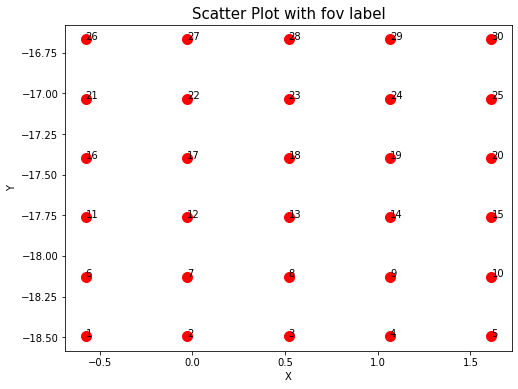

In [30]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(20)

X=np.random.randint(10, size=(5))
Y=np.random.randint(10, size=(5))

X = x_coordinate
Y = y_coordinate

annotations=["Point-1","Point-2","Point-3","Point-4","Point-5"]
annotations = list(fov_position["fov"])

plt.figure(figsize=(8,6))
plt.scatter(X,Y,s=100,color="red")
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Scatter Plot with fov label",fontsize=15)
for i, label in enumerate(annotations):
    plt.annotate(label, (X[i], Y[i]))

plt.show()

In [31]:

fov_spot_coordinates = pd.DataFrame(columns = ['fov', 'spot_id', 'x', 'y'])
fov_spot_coordinates                                               

,fov,spot_id,x,y


In [32]:


def get_spot_x_y_range(x_global_px, y_global_px, fov_id, fov_spot_coordinates):
    fov_length = 5472
    fov_width = 3648
    x_l = x_global_px
    y_l = y_global_px
    x_h = x_l + fov_length
    y_h = y_l + fov_width
    
    spot_id = 1
    x = x_l + (5472/10.0) * 1
    y = y_h - (3648/8.0) * 1
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)

    spot_id = 2
    x = x_l + (5472/10.0) * 1
    y = y_h - (3648/8.0) * 1 - (3648/4.0) * 1
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)

    spot_id = 3
    x = x_l + (5472/10.0) * 1
    y = y_h - (3648/8.0) * 1 - (3648/4.0) * 2
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
   
    spot_id = 4
    x = x_l + (5472/10.0) * 1
    y = y_h - (3648/8.0) * 1 - (3648/4.0) * 3
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)

    # ---------
    spot_id = 5
    x = x_l + (5472/10.0) * 1 + (5472/5.0) * 1
    y = y_h - (3648/8.0) * 1
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)

    spot_id = 6
    x = x_l + (5472/10.0) * 1 + (5472/5.0) * 1
    y = y_h - (3648/8.0) * 1 - (3648/4.0) * 1
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)

    spot_id = 7
    x = x_l + (5472/10.0) * 1 + (5472/5.0) * 1
    y = y_h - (3648/8.0) * 1 - (3648/4.0) * 2
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
   
    spot_id = 8
    x = x_l + (5472/10.0) * 1 + (5472/5.0) * 1
    y = y_h - (3648/8.0) * 1 - (3648/4.0) * 3
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
   
   # -----------
    spot_id = 9
    x = x_l + (5472/10.0) * 1 + (5472/5.0) * 2
    y = y_h - (3648/8.0) * 1
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)

    spot_id = 10
    x = x_l + (5472/10.0) * 1 + (5472/5.0) * 2
    y = y_h - (3648/8.0) * 1 - (3648/4.0) * 1
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)

    spot_id = 11
    x = x_l + (5472/10.0) * 1 + (5472/5.0) * 2
    y = y_h - (3648/8.0) * 1 - (3648/4.0) * 2
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
   
    spot_id = 12
    x = x_l + (5472/10.0) * 1 + (5472/5.0) * 2
    y = y_h - (3648/8.0) * 1 - (3648/4.0) * 3
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)

    # -----------
    spot_id = 13
    x = x_l + (5472/10.0) * 1 + (5472/5.0) * 3
    y = y_h - (3648/8.0) * 1
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)

    spot_id = 14
    x = x_l + (5472/10.0) * 1 + (5472/5.0) * 3
    y = y_h - (3648/8.0) * 1 - (3648/4.0) * 1
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)

    spot_id = 15
    x = x_l + (5472/10.0) * 1 + (5472/5.0) * 3
    y = y_h - (3648/8.0) * 1 - (3648/4.0) * 2
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
   
    spot_id = 16
    x = x_l + (5472/10.0) * 1 + (5472/5.0) * 3
    y = y_h - (3648/8.0) * 1 - (3648/4.0) * 3
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
   
    # -----------
    spot_id = 17
    x = x_l + (5472/10.0) * 1 + (5472/5.0) * 4
    y = y_h - (3648/8.0) * 1
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)

    spot_id = 18
    x = x_l + (5472/10.0) * 1 + (5472/5.0) * 4
    y = y_h - (3648/8.0) * 1 - (3648/4.0) * 1
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)

    spot_id = 19
    x = x_l + (5472/10.0) * 1 + (5472/5.0) * 4
    y = y_h - (3648/8.0) * 1 - (3648/4.0) * 2
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
   
    spot_id = 20
    x = x_l + (5472/10.0) * 1 + (5472/5.0) * 4
    y = y_h - (3648/8.0) * 1 - (3648/4.0) * 3
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
    
    
    fov_spot_coordinates['x'] = fov_spot_coordinates['x'] 
    fov_spot_coordinates['y'] = fov_spot_coordinates['y']
    
    return fov_spot_coordinates
    

In [33]:
coordinates = get_spot_x_y_range(-25727.777778, -164066.666667, 8, fov_spot_coordinates)
coordinates

/tmp/ipykernel_1851/4274499263.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
/tmp/ipykernel_1851/4274499263.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
/tmp/ipykernel_1851/4274499263.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
/tmp/ipykernel_1851/4274499263.py:27: FutureWarning: The frame.append method is deprecated and will be rem

,fov,spot_id,x,y
0,8.0,1.0,-25180.577778,-160874.666667
1,8.0,2.0,-25180.577778,-161786.666667
2,8.0,3.0,-25180.577778,-162698.666667
3,8.0,4.0,-25180.577778,-163610.666667
4,8.0,5.0,-24086.177778,-160874.666667
5,8.0,6.0,-24086.177778,-161786.666667
6,8.0,7.0,-24086.177778,-162698.666667
7,8.0,8.0,-24086.177778,-163610.666667
8,8.0,9.0,-22991.777778,-160874.666667
9,8.0,10.0,-22991.777778,-161786.666667


# Benchmark Generation

In [33]:
"""
1 μm(micrometer) = 1e-4 cm
GeoMx: spot region area
1. mean: 37456.28 μm2
2. median: 24168.74 μm2
"""

'\nGeoMx: spot region area\n1. mean: 37456.28 μm2\n2. median: 24168.74 μm2\n'

In [34]:
"""
CosMx lung: 
1. All FOVs are the same dimension, 5472 x 3648 pixels
2. multiply the pixel value by 0.18 um per pixel
3. FOV area: 5472 x 3648 pixels -> 984.96um x 656.64um = 646,764.134 um2 
"""

'\nCosMx lung: \n1. All FOVs are the same dimension, 5472 x 3648 pixels\n2. multiply the pixel value by 0.18 um per pixel\n3. FOV area: 5472 x 3648 pixels -> 984.96um x 656.64um = 646,764.134 um2 \n'

In [35]:
"""
New Benchamrk from CosMx
1. length: 5472 pixels, width: 3648 pixels
2. simulated spot: 
    length: 5472 pixels / 5 = 1094.4 pixel = 196.992 um
    width: 3648 pixels / 4 = 912 pixel = 164.16 um
    one spot area: 196.992 um * 164.16 um = 32338.2067 um2
3. In total: 20 spots / FOV
"""

'\nNew Benchamrk from CosMx\n1. length: 5472 pixels, width: 3648 pixels\n2. simulated spot: \n    length: 5472 pixels / 5 = 1094.4 pixel = 196.992 um\n    width: 3648 pixels / 4 = 912 pixel = 164.16 um\n    one spot area: 196.992 um * 164.16 um = 32338.2067 um2\n3. In total: 20 spots / FOV\n'

In [36]:
"""
CosMx Kidey dataset:
Assume FOV size on kidney is 5472 x 3648 pixels.

so the pseudo spot still be: 
    length: 5472 pixels / 5 = 1094.4 pixel = 196.992 um
    width: 3648 pixels / 4 = 912 pixel = 164.16 um

"""

'\nCosMx Kidey dataset:\nAssume FOV size on kidney is 5472 x 3648 pixels.\n\nso the pseudo spot still be: \n    length: 5472 pixels / 5 = 1094.4 pixel = 196.992 um\n    width: 3648 pixels / 4 = 912 pixel = 164.16 um\n\n'

In [37]:
"""
spot_fov_cellId_mapping.csv (spot_id, fov, cell_Id)

spot_gene_expression.csv (spot_id, gene1, gene2, gene3...)
"""

'\nspot_fov_cellId_mapping.csv (spot_id, fov, cell_Id)\n\nspot_gene_expression.csv (spot_id, gene1, gene2, gene3...)\n'

## 1. spot_fov_cellId_mapping.csv

In [34]:
def get_spot_fov_cellId_mapping(data_result, cell_boundary_fov_11):
    new_col_val = cell_boundary_fov_11.shape[0]* [0]
    cell_boundary_fov_11.insert(loc=0, column='spot_id', value=new_col_val)

    for i in range(cell_boundary_fov_11.shape[0]):
        one_row_sample = cell_boundary_fov_11.iloc[i]
        if one_row_sample["CenterX_local_px"] <= 1094.4 * 1:
            if one_row_sample["CenterY_local_px"] <= 912 * 1:
                spot_id = 1
            elif one_row_sample["CenterY_local_px"] <= 912 * 2:
                spot_id = 2
            elif one_row_sample["CenterY_local_px"] <= 912 * 3:
                spot_id = 3
            elif one_row_sample["CenterY_local_px"] <= 912 * 4:
                spot_id = 4

        elif one_row_sample["CenterX_local_px"] <= 1094.4 * 2:
            if one_row_sample["CenterY_local_px"] <= 912 * 1:
                spot_id = 5
            elif one_row_sample["CenterY_local_px"] <= 912 * 2:
                spot_id = 6
            elif one_row_sample["CenterY_local_px"] <= 912 * 3:
                spot_id = 7
            elif one_row_sample["CenterY_local_px"] <= 912 * 4:
                spot_id = 8

        elif one_row_sample["CenterX_local_px"] <= 1094.4 * 3:
            if one_row_sample["CenterY_local_px"] <= 912 * 1:
                spot_id = 9
            elif one_row_sample["CenterY_local_px"] <= 912 * 2:
                spot_id = 10
            elif one_row_sample["CenterY_local_px"] <= 912 * 3:
                spot_id = 11
            elif one_row_sample["CenterY_local_px"] <= 912 * 4:
                spot_id = 12

        elif one_row_sample["CenterX_local_px"] <= 1094.4 * 4:
            if one_row_sample["CenterY_local_px"] <= 912 * 1:
                spot_id = 13
            elif one_row_sample["CenterY_local_px"] <= 912 * 2:
                spot_id = 14
            elif one_row_sample["CenterY_local_px"] <= 912 * 3:
                spot_id = 15
            elif one_row_sample["CenterY_local_px"] <= 912 * 4:
                spot_id = 16

        elif one_row_sample["CenterX_local_px"] <= 1094.4 * 5:
            if one_row_sample["CenterY_local_px"] <= 912 * 1:
                spot_id = 17
            elif one_row_sample["CenterY_local_px"] <= 912 * 2:
                spot_id = 18
            elif one_row_sample["CenterY_local_px"] <= 912 * 3:
                spot_id = 19
            elif one_row_sample["CenterY_local_px"] <= 912 * 4:
                spot_id = 20
        else:
            print("Wrong CenterX_local_px")
        data_result = data_result.append({'spot_id' : spot_id, 'fov' : one_row_sample["fov"], 'cell_ID' : one_row_sample["cell_ID"]}, ignore_index = True)

    return data_result

        

In [35]:
data_final_result = pd.DataFrame(columns = [ 'fov', 'spot_id', 'cell_ID'])
data_final_result

,fov,spot_id,cell_ID


In [36]:
cell_boundary

,fov,cell_ID,Area,AspectRatio,CenterX_local_px,CenterY_local_px,CenterX_global_px,CenterY_global_px,Width,Height,Mean.MembraneStain,Max.MembraneStain,Mean.PanCK,Max.PanCK,Mean.CD45,Max.CD45,Mean.CD3,Max.CD3,Mean.DAPI,Max.DAPI
0,1,1,4099,0.92,305,3609,-5450.555556,-181318.777778,73,79,1370,4222,483,7430,170,738,0,0,5842,24372
1,1,2,5109,1.52,426,3615,-5329.555556,-181312.777778,100,66,1681,8627,263,544,58,343,0,0,496,8936
2,1,3,2930,1.00,787,3615,-4968.555556,-181312.777778,67,67,4526,11172,457,1694,645,2808,0,30,4814,31312
3,1,4,2354,1.31,852,3624,-4903.555556,-181303.777778,64,49,4252,16462,5833,18264,301,1057,0,0,4912,21525
4,1,5,2657,1.18,2447,3623,-3308.555556,-181304.777778,59,50,700,1542,5816,18220,168,623,0,8,3950,13319
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93790,30,2753,1757,3.40,3348,14,19481.333333,-166663.777778,85,25,569,1533,1772,13021,128,455,0,0,2431,7588
93791,30,2754,1262,2.83,2367,13,18500.333333,-166664.777778,65,23,945,1535,11164,33470,169,421,0,0,5824,26886
93792,30,2755,1295,3.09,4763,13,20896.333333,-166664.777778,71,23,477,1114,31098,65181,175,445,0,0,9315,27557
93793,30,2756,1019,2.76,2931,12,19064.333333,-166665.777778,58,21,1035,3413,462,1766,160,515,0,44,2562,11646


In [37]:
type(cell_boundary)

pandas.core.frame.DataFrame

In [38]:
fov_ids_lst = cell_boundary['fov'].unique()
fov_ids_lst

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30])

In [39]:
for fov_id in fov_ids_lst:
    print("fov_id:", fov_id, cell_boundary[(cell_boundary['fov']==fov_id)].shape)

fov_id: 1 (2797, 20)
fov_id: 2 (3489, 20)
fov_id: 3 (3309, 20)
fov_id: 4 (3310, 20)
fov_id: 5 (3027, 20)
fov_id: 6 (3325, 20)
fov_id: 7 (3477, 20)
fov_id: 8 (3250, 20)
fov_id: 9 (3386, 20)
fov_id: 10 (2928, 20)
fov_id: 11 (3062, 20)
fov_id: 12 (3238, 20)
fov_id: 13 (2972, 20)
fov_id: 14 (2919, 20)
fov_id: 15 (2446, 20)
fov_id: 16 (2924, 20)
fov_id: 17 (3301, 20)
fov_id: 18 (3468, 20)
fov_id: 19 (2863, 20)
fov_id: 20 (2591, 20)
fov_id: 21 (2891, 20)
fov_id: 22 (3209, 20)
fov_id: 23 (3913, 20)
fov_id: 24 (3664, 20)
fov_id: 25 (2646, 20)
fov_id: 26 (2880, 20)
fov_id: 27 (3227, 20)
fov_id: 28 (3175, 20)
fov_id: 29 (3351, 20)
fov_id: 30 (2757, 20)


In [40]:
cell_boundary[(cell_boundary['fov']==14)]["CenterX_global_px"].tolist()

[13208.1111111111,
 13400.1111111111,
 13863.1111111111,
 11761.1111111111,
 11829.1111111111,
 11968.1111111111,
 12231.1111111111,
 12768.1111111111,
 12967.1111111111,
 12116.1111111111,
 11947.1111111111,
 12847.1111111111,
 12196.1111111111,
 11190.1111111111,
 10831.1111111111,
 11016.1111111111,
 13381.1111111111,
 13761.1111111111,
 13429.1111111111,
 13886.1111111111,
 11346.1111111111,
 16071.1111111111,
 11743.1111111111,
 13661.1111111111,
 10711.1111111111,
 10672.1111111111,
 10854.1111111111,
 13334.1111111111,
 12359.1111111111,
 11036.1111111111,
 11697.1111111111,
 13611.1111111111,
 10920.1111111111,
 10709.1111111111,
 13984.1111111111,
 10730.1111111111,
 10789.1111111111,
 13487.1111111111,
 10864.1111111111,
 12120.1111111111,
 14626.1111111111,
 13766.1111111111,
 10919.1111111111,
 10828.1111111111,
 13189.1111111111,
 11499.1111111111,
 10680.1111111111,
 11220.1111111111,
 11689.1111111111,
 13533.1111111111,
 14041.1111111111,
 11552.1111111111,
 15532.11111

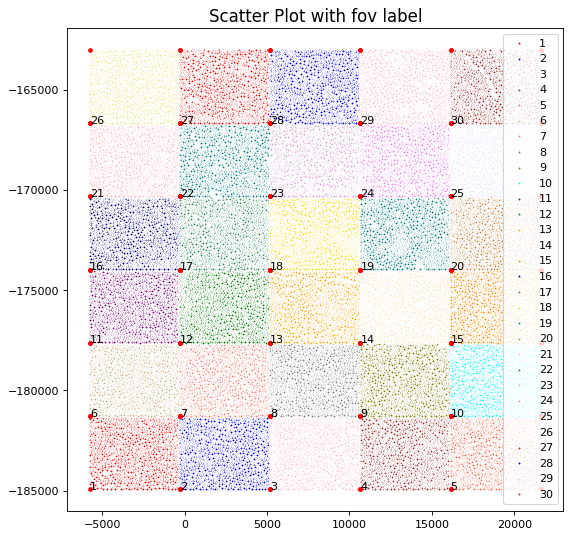

In [41]:
import numpy as np
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 8), dpi=80)

np.random.seed(20)
color = ["red", "blue", "pink", "brown", "tomato", "tan", "salmon", "gray", "olive", \
         "cyan", "purple", "green", "orange", "bisque", "darkorange", "navy", "seagreen", \
         "gold", "teal", "peru", "lightpink", "teal", "plum", "violet", "lavender", "khaki",\
        "red", "blue", "pink", "brown", "tomato", "tan", "salmon", "gray", "olive",\
        "cyan", "purple", "green", "orange", "bisque", "darkorange", "navy", "seagreen",\
        "gold", "teal", "peru", "lightpink", "teal", "plum", "violet", "lavender", "khaki",\
         "red", "blue", "pink", "brown", "tomato", "tan", "salmon", "gray", "olive", \
         "cyan", "purple", "green", "orange", "bisque", "darkorange", "navy", "seagreen", \
         "gold", "teal", "peru", "lightpink", "teal", "plum", "violet", "lavender", "khaki"
        ]
for i in range(len(fov_ids_lst)):
    fov_id = fov_ids_lst[i]
    X = cell_boundary[(cell_boundary['fov']==fov_id)]["CenterX_global_px"].tolist()
    Y = cell_boundary[(cell_boundary['fov']==fov_id)]["CenterY_global_px"].tolist()

    plt.scatter(X, Y, s=30, label = fov_id, c = color[i], marker='.', alpha = None, edgecolors= 'white')
    plt.legend()

X = fov_position["x_global_px"].tolist()
Y = fov_position["y_global_px"].tolist()

X_plus = [i+ 5472 for i in X]
Y_plus = [i+3648 for i in Y]

annotations=["Point-1","Point-2","Point-3","Point-4","Point-5"]
annotations = (fov_position["fov"]).tolist()

plt.scatter(X,Y,s=10,color="red")
plt.scatter(X_plus, Y_plus,s=10,color="red")
plt.scatter(X_plus, Y,s=10,color="red")
plt.scatter(X, Y_plus,s=10,color="red")


plt.title("Scatter Plot with fov label",fontsize=15)
for i, label in enumerate(annotations):
    plt.annotate(label, (X[i], Y[i]))


plt.show()


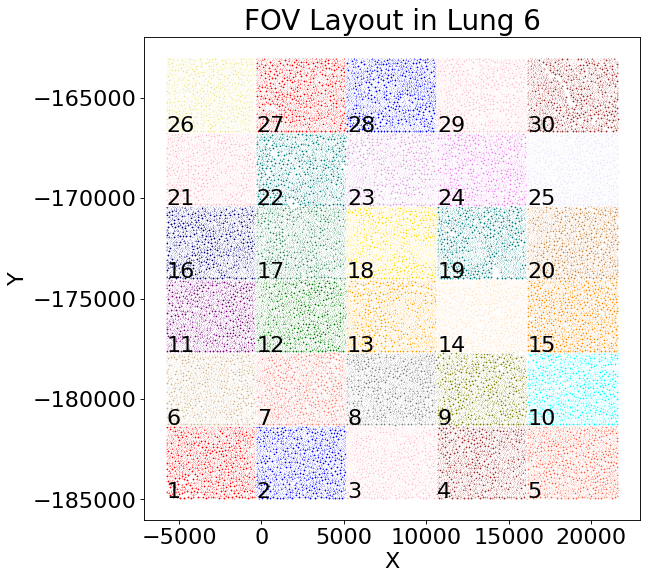

In [58]:
import numpy as np
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 8), dpi=80)

np.random.seed(20)
color = ["red", "blue", "pink", "brown", "tomato", "tan", "salmon", "gray", "olive", \
         "cyan", "purple", "green", "orange", "bisque", "darkorange", "navy", "seagreen", \
         "gold", "teal", "peru", "lightpink", "teal", "plum", "violet", "lavender", "khaki",\
        "red", "blue", "pink", "brown", "tomato", "tan", "salmon", "gray", "olive",\
        "cyan", "purple", "green", "orange", "bisque", "darkorange", "navy", "seagreen",\
        "gold", "teal", "peru", "lightpink", "teal", "plum", "violet", "lavender", "khaki",\
         "red", "blue", "pink", "brown", "tomato", "tan", "salmon", "gray", "olive", \
         "cyan", "purple", "green", "orange", "bisque", "darkorange", "navy", "seagreen", \
         "gold", "teal", "peru", "lightpink", "teal", "plum", "violet", "lavender", "khaki"
        ]
for i in range(len(fov_ids_lst)):
    fov_id = fov_ids_lst[i]
    X = cell_boundary[(cell_boundary['fov']==fov_id)]["CenterX_global_px"].tolist()
    Y = cell_boundary[(cell_boundary['fov']==fov_id)]["CenterY_global_px"].tolist()

    plt.scatter(X, Y, s=30, label = fov_id, c = color[i], marker='.', alpha = None, edgecolors= 'white')
#     plt.legend()

X = fov_position["x_global_px"].tolist()
Y = fov_position["y_global_px"].tolist()

X_plus = [i+ 5472 for i in X]
Y_plus = [i+3648 for i in Y]

annotations=["Point-1","Point-2","Point-3","Point-4","Point-5"]
annotations = (fov_position["fov"]).tolist()

# plt.scatter(X,Y,s=10,color="red")
# plt.scatter(X_plus, Y_plus,s=10,color="red")
# plt.scatter(X_plus, Y,s=10,color="red")
# plt.scatter(X, Y_plus,s=10,color="red")

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('X', fontsize=20)
plt.ylabel('Y', fontsize=20)
plt.title("FOV Layout in Lung 6",fontsize=25)
for i, label in enumerate(annotations):
    plt.annotate(label, (X[i], Y[i]), size=20)

plt.savefig("../../FOV_layout/Lung6.png", format="png", bbox_inches="tight")
plt.show()


In [50]:
fov_ids_lst = cell_boundary['fov'].unique()
print("fov_ids_lst:", fov_ids_lst)

for fov_id in fov_ids_lst:
    print("fov_id:", fov_id)
    cell_boundary_fov =  cell_boundary[(cell_boundary['fov']==fov_id)]
    print("cell_boundary_fov_without_spot_id:", cell_boundary_fov.shape)
    data_final_result = get_spot_fov_cellId_mapping(data_final_result, cell_boundary_fov)

data_final_result

fov_ids_lst: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30]
fov_id: 1
cell_boundary_fov_without_spot_id: (2797, 20)
fov_id: 2
cell_boundary_fov_without_spot_id: (3489, 20)
fov_id: 3
cell_boundary_fov_without_spot_id: (3309, 20)
fov_id: 4
cell_boundary_fov_without_spot_id: (3310, 20)
fov_id: 5
cell_boundary_fov_without_spot_id: (3027, 20)
fov_id: 6
cell_boundary_fov_without_spot_id: (3325, 20)
fov_id: 7
cell_boundary_fov_without_spot_id: (3477, 20)
fov_id: 8
cell_boundary_fov_without_spot_id: (3250, 20)
fov_id: 9
cell_boundary_fov_without_spot_id: (3386, 20)
fov_id: 10
cell_boundary_fov_without_spot_id: (2928, 20)
fov_id: 11
cell_boundary_fov_without_spot_id: (3062, 20)
fov_id: 12
cell_boundary_fov_without_spot_id: (3238, 20)
fov_id: 13
cell_boundary_fov_without_spot_id: (2972, 20)
fov_id: 14
cell_boundary_fov_without_spot_id: (2919, 20)
fov_id: 15
cell_boundary_fov_without_spot_id: (2446, 20)
fov_id: 16
cell_boundary_fov_without_spot_id: (2

,fov,spot_id,cell_ID
0,1.0,4.0,1.0
1,1.0,4.0,2.0
2,1.0,4.0,3.0
3,1.0,4.0,4.0
4,1.0,12.0,5.0
...,...,...,...
93790,30.0,13.0,2753.0
93791,30.0,9.0,2754.0
93792,30.0,17.0,2755.0
93793,30.0,9.0,2756.0


In [53]:
data_final_result

,fov,spot_id,cell_ID
0,1.0,4.0,1.0
1,1.0,4.0,2.0
2,1.0,4.0,3.0
3,1.0,4.0,4.0
4,1.0,12.0,5.0
...,...,...,...
93790,30.0,13.0,2753.0
93791,30.0,9.0,2754.0
93792,30.0,17.0,2755.0
93793,30.0,9.0,2756.0


In [54]:
data_final_result_sample = data_final_result[(data_final_result['fov']==14)]
data_final_result_sample

,fov,spot_id,cell_ID
41570,14.0,12.0,1.0
41571,14.0,12.0,2.0
41572,14.0,12.0,3.0
41573,14.0,8.0,4.0
41574,14.0,8.0,5.0
...,...,...,...
44484,14.0,13.0,2915.0
44485,14.0,9.0,2916.0
44486,14.0,5.0,2917.0
44487,14.0,13.0,2918.0


In [56]:
data_final_result.to_csv('../Lung6/Lung6-Flat_files_and_images/new/spot_fov_cellId_mapping.csv')

In [57]:
data_final_result

,fov,spot_id,cell_ID
0,1.0,4.0,1.0
1,1.0,4.0,2.0
2,1.0,4.0,3.0
3,1.0,4.0,4.0
4,1.0,12.0,5.0
...,...,...,...
93790,30.0,13.0,2753.0
93791,30.0,9.0,2754.0
93792,30.0,17.0,2755.0
93793,30.0,9.0,2756.0


## 2. spot_gene_expression.csv

In [58]:
data_final_result = pd.read_csv('../Lung6/Lung6-Flat_files_and_images/new/spot_fov_cellId_mapping.csv')
data_final_result

,Unnamed: 0,fov,spot_id,cell_ID
0,0,1.0,4.0,1.0
1,1,1.0,4.0,2.0
2,2,1.0,4.0,3.0
3,3,1.0,4.0,4.0
4,4,1.0,12.0,5.0
...,...,...,...,...
93790,93790,30.0,13.0,2753.0
93791,93791,30.0,9.0,2754.0
93792,93792,30.0,17.0,2755.0
93793,93793,30.0,9.0,2756.0


In [59]:
gene_expression

,fov,cell_ID,AATK,ABL1,ABL2,ACE,ACE2,ACKR1,ACKR3,ACKR4,...,NegPrb14,NegPrb15,NegPrb16,NegPrb17,NegPrb18,NegPrb19,NegPrb20,NegPrb21,NegPrb22,NegPrb23
0,1,0,5,50,48,47,15,14,21,13,...,15,10,27,28,11,23,21,25,17,9
1,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93820,30,2753,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
93821,30,2754,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
93822,30,2755,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
93823,30,2756,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [60]:
fov_spot_cells_stats = pd.DataFrame(columns = ['fov', 'spot-id=1', 'spot-id=2', 'spot-id=3','spot-id=4', 'spot-id=5', 'spot-id=6', 'spot-id=7', 'spot-id=8', 'spot-id=9','spot-id=10', 'spot-id=11', 'spot-id=12', 'spot-id=13','spot-id=14', 'spot-id=15', 'spot-id=16', 'spot-id=17', 'spot-id=18', 'spot-id=19','spot-id=20'])
fov_spot_cells_stats


,fov,spot-id=1,spot-id=2,spot-id=3,spot-id=4,spot-id=5,spot-id=6,spot-id=7,spot-id=8,spot-id=9,...,spot-id=11,spot-id=12,spot-id=13,spot-id=14,spot-id=15,spot-id=16,spot-id=17,spot-id=18,spot-id=19,spot-id=20


In [61]:
names = ['fov', 'spot-id=1', 'spot-id=2', 'spot-id=3','spot-id=4', 'spot-id=5', 'spot-id=6', 'spot-id=7', 'spot-id=8', 'spot-id=9','spot-id=10', 'spot-id=11', 'spot-id=12', 'spot-id=13','spot-id=14', 'spot-id=15', 'spot-id=16', 'spot-id=17', 'spot-id=18', 'spot-id=19','spot-id=20']
fov_dic = {}
for i in names:
    fov_dic[i] = 0
fov_dic



{'fov': 0,
 'spot-id=1': 0,
 'spot-id=2': 0,
 'spot-id=3': 0,
 'spot-id=4': 0,
 'spot-id=5': 0,
 'spot-id=6': 0,
 'spot-id=7': 0,
 'spot-id=8': 0,
 'spot-id=9': 0,
 'spot-id=10': 0,
 'spot-id=11': 0,
 'spot-id=12': 0,
 'spot-id=13': 0,
 'spot-id=14': 0,
 'spot-id=15': 0,
 'spot-id=16': 0,
 'spot-id=17': 0,
 'spot-id=18': 0,
 'spot-id=19': 0,
 'spot-id=20': 0}

In [62]:
fov_ids_lst = cell_boundary['fov'].unique()
spot_id_lst = [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

for fov_id in fov_ids_lst:
    fov_data = data_final_result[(data_final_result['fov']==fov_id)]
    
    fov_dic_sample = fov_dic
    fov_dic_sample["fov"] = fov_id
    
    for i in spot_id_lst:
        spot_id_data = fov_data[(fov_data['spot_id']==i)]
        spot_id_num = "spot-id=" + str(i)
        fov_dic_sample[spot_id_num] = spot_id_data.shape[0]
    fov_spot_cells_stats = fov_spot_cells_stats.append(fov_dic_sample, ignore_index = True)



In [63]:
fov_spot_cells_stats.to_csv('../Lung6/Lung6-Flat_files_and_images/new/fov_new_spot_cell_stats.csv')
fov_spot_cells_stats

,fov,spot-id=1,spot-id=2,spot-id=3,spot-id=4,spot-id=5,spot-id=6,spot-id=7,spot-id=8,spot-id=9,...,spot-id=11,spot-id=12,spot-id=13,spot-id=14,spot-id=15,spot-id=16,spot-id=17,spot-id=18,spot-id=19,spot-id=20
0,1,49,127,136,165,73,122,128,122,155,...,150,164,159,137,128,170,131,162,189,153
1,2,160,197,197,184,169,169,191,210,163,...,181,211,135,168,132,154,176,206,169,145
2,3,191,154,154,139,184,165,174,155,158,...,171,179,128,187,154,165,132,188,205,148
3,4,172,153,141,141,180,154,181,176,172,...,143,142,186,180,169,151,159,197,180,171
4,5,178,183,127,139,177,160,117,126,183,...,124,129,177,156,148,124,155,178,183,127
5,6,184,213,165,205,162,174,150,172,150,...,152,158,161,155,184,173,163,153,135,130
6,7,184,181,182,192,167,162,182,230,202,...,172,184,153,167,187,126,160,121,213,147
7,8,180,173,190,169,167,191,151,163,159,...,193,152,162,175,167,145,159,130,112,128
8,9,163,177,166,144,228,195,166,156,206,...,185,167,178,169,130,87,166,180,154,164
9,10,163,143,136,170,154,172,111,178,151,...,118,151,145,165,148,148,133,145,115,101


In [64]:
data_final_result[(data_final_result['fov']==fov_id)]

,Unnamed: 0,fov,spot_id,cell_ID
91038,91038,30.0,4.0,1.0
91039,91039,30.0,4.0,2.0
91040,91040,30.0,4.0,3.0
91041,91041,30.0,4.0,4.0
91042,91042,30.0,8.0,5.0
...,...,...,...,...
93790,93790,30.0,13.0,2753.0
93791,93791,30.0,9.0,2754.0
93792,93792,30.0,17.0,2755.0
93793,93793,30.0,9.0,2756.0


In [65]:
spot_gene_expression = ["fov", "spot_id"]
genes_name_lst = (gene_expression.columns)[2:].tolist()
spot_gene_expression = spot_gene_expression + genes_name_lst
spot_gene_expression

['fov',
 'spot_id',
 'AATK',
 'ABL1',
 'ABL2',
 'ACE',
 'ACE2',
 'ACKR1',
 'ACKR3',
 'ACKR4',
 'ACTA2',
 'ACTG2',
 'ACVR1',
 'ACVR1B',
 'ACVR2A',
 'ACVRL1',
 'ADGRA2',
 'ADGRA3',
 'ADGRB2',
 'ADGRB3',
 'ADGRD1',
 'ADGRE1',
 'ADGRE2',
 'ADGRE5',
 'ADGRF1',
 'ADGRF3',
 'ADGRF4',
 'ADGRF5',
 'ADGRG1',
 'ADGRG2',
 'ADGRG3',
 'ADGRG5',
 'ADGRG6',
 'ADGRL1',
 'ADGRL2',
 'ADGRL4',
 'ADGRV1',
 'ADIPOQ',
 'ADIRF',
 'ADM2',
 'ADORA2A',
 'AGR2',
 'AHI1',
 'AHR',
 'AKT1',
 'ALCAM',
 'ANGPT1',
 'ANGPT2',
 'ANGPT4',
 'ANGPTL1',
 'ANXA1',
 'ANXA2',
 'ANXA4',
 'APOA1',
 'APOB',
 'APOD',
 'APP',
 'AQP3',
 'AR',
 'AREG',
 'ARF1',
 'ARG1',
 'ARHGDIB',
 'ARTN',
 'ATF3',
 'ATG10',
 'ATG12',
 'ATG5',
 'ATM',
 'ATR',
 'AXL',
 'AZGP1',
 'AZU1',
 'B2M',
 'B3GNT7',
 'BAG3',
 'BATF3',
 'BAX',
 'BCL2',
 'BCL2L1',
 'BECN1',
 'BEST1',
 'BGN',
 'BID',
 'BIRC5',
 'BMP1',
 'BMP2',
 'BMP3',
 'BMP4',
 'BMP5',
 'BMP6',
 'BMP7',
 'BMPR1A',
 'BMPR2',
 'BMX',
 'BRCA1',
 'BST1',
 'BST2',
 'BTG1',
 'BTK',
 'C11orf96',
 'C1QA'

In [66]:
spot_gene_expression = pd.DataFrame(columns = spot_gene_expression)
spot_gene_expression


,fov,spot_id,AATK,ABL1,ABL2,ACE,ACE2,ACKR1,ACKR3,ACKR4,...,NegPrb14,NegPrb15,NegPrb16,NegPrb17,NegPrb18,NegPrb19,NegPrb20,NegPrb21,NegPrb22,NegPrb23


In [67]:
def get_spot_gene_expression(spot_cell_mapping, fov_expression, spot_id):
    genes_lst = (fov_expression.columns)[2:].tolist()
    
#     gene_count_dic = {}
#     for gene_name in genes_lst:
#         gene_count_dic[gene_name] = 0
    
    cell_id_lst = spot_cell_mapping[(spot_cell_mapping['spot_id']==spot_id)]["cell_ID"].tolist()
    
    cell_gene_expression_total = len(genes_lst)*[0]
    for cell_id in cell_id_lst:
        cell_gene_expression = fov_expression[(fov_expression['cell_ID'] == cell_id)]
        cell_gene_expression = cell_gene_expression.values.tolist()[0][2:]
        cell_gene_expression_total = np.sum([cell_gene_expression_total, cell_gene_expression], axis=0).tolist()
                
#         for gene_name in genes_lst:
#             gene_count_dic[gene_name] = gene_count_dic[gene_name] + cell_gene_expression[gene_name]
    
    return cell_gene_expression_total
    
    
    
        
    
    

In [68]:
fov_ids_lst = cell_boundary['fov'].unique()
spot_id_lst = [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

for fov_id in fov_ids_lst:
    fov_data = data_final_result[(data_final_result['fov']==fov_id)]
    print("fov_id:", fov_id)
#     print("fov_data", fov_data)
    fov_gene_expression = gene_expression[(gene_expression['fov'] == fov_id)]
#     print("fov_gene_expression:", fov_gene_expression)
    
    for spot_id in spot_id_lst:
        to_append = [fov_id, spot_id]
        spot_gene_express = get_spot_gene_expression(fov_data, fov_gene_expression, spot_id)
        to_append = to_append + spot_gene_express
        a_series = pd.Series(to_append, index = spot_gene_expression.columns)
        spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
       
#     print(spot_gene_express, len(spot_gene_express))
    
    
  

fov_id: 1
fov_id: 2
fov_id: 3
fov_id: 4
fov_id: 5
fov_id: 6
fov_id: 7
fov_id: 8
fov_id: 9
fov_id: 10
fov_id: 11
fov_id: 12
fov_id: 13
fov_id: 14
fov_id: 15
fov_id: 16
fov_id: 17
fov_id: 18
fov_id: 19
fov_id: 20
fov_id: 21
fov_id: 22
fov_id: 23
fov_id: 24
fov_id: 25
fov_id: 26
fov_id: 27
fov_id: 28
fov_id: 29
fov_id: 30


In [71]:
spot_gene_expression

,fov,spot_id,AATK,ABL1,ABL2,ACE,ACE2,ACKR1,ACKR3,ACKR4,...,NegPrb14,NegPrb15,NegPrb16,NegPrb17,NegPrb18,NegPrb19,NegPrb20,NegPrb21,NegPrb22,NegPrb23
0,1,1,0,0,1,3,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0
1,1,2,4,1,5,2,0,3,0,3,...,1,2,0,0,1,3,3,3,0,2
2,1,3,3,21,19,13,4,4,5,4,...,3,2,1,5,1,5,2,5,8,2
3,1,4,3,17,4,10,2,4,3,1,...,2,1,0,0,1,1,0,3,4,3
4,1,5,1,2,8,2,2,1,3,3,...,2,3,2,0,0,3,4,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,30,16,0,6,7,4,3,2,14,8,...,5,4,1,3,0,2,4,1,0,2
596,30,17,0,1,7,3,2,6,1,4,...,2,1,0,3,0,3,2,0,0,0
597,30,18,1,4,8,7,3,23,8,3,...,2,4,0,0,0,3,6,1,0,3
598,30,19,0,5,8,4,8,8,7,6,...,0,3,3,4,1,2,2,0,1,3


In [72]:
spot_gene_expression.to_csv('../Lung6/Lung6-Flat_files_and_images/new/spot_gene_expression.csv')

## 3. Ground Truth

In [135]:
CosMx_cell_type = pd.read_csv('../cosMX_showcase_meta.csv')
CosMx_cell_type

,Unnamed: 0,cell_ID,fov,Area,AspectRatio,Width,Height,Mean.CD298,Max.CD298,Mean.G,...,Panel,Diversity,totalcounts,log10totalcounts,background,remove_flagged_cells,patient,cell_type,niche,prop_tumor_in_100_neighbors
0,1,c_1_1_1,1,1259,1.34,47,35,3473,7354,715,...,980p,19,23,1.361728,0.004956,False,Lung5,mDC,plasmablast-enriched stroma,0.09
1,2,c_1_1_2,1,3723,1.45,87,60,3895,13832,18374,...,980p,23,26,1.414973,0.005603,False,Lung5,endothelial,stroma,0.00
2,3,c_1_1_3,1,2010,1.62,68,42,2892,6048,3265,...,980p,51,74,1.869232,0.015946,False,Lung5,endothelial,stroma,0.01
3,4,c_1_1_4,1,3358,0.47,48,102,6189,16091,485,...,980p,48,60,1.778151,0.012929,False,Lung5,pDC,stroma,0.00
4,5,c_1_1_5,1,1213,1.00,38,38,8138,19281,549,...,980p,39,52,1.716003,0.011205,False,Lung5,macrophage,stroma,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
771231,771232,c_8_20_3999,20,1314,1.02,45,44,7430,9572,370,...,980p,87,135,2.130334,0.029091,False,Lung13,T CD4 memory,immune,0.34
771232,771233,c_8_20_4000,20,1549,1.71,60,35,8362,11209,161,...,980p,60,74,1.869232,0.015946,False,Lung13,T CD4 memory,immune,0.30
771233,771234,c_8_20_4001,20,2829,2.75,99,36,5158,10180,634,...,980p,69,102,2.008600,0.021980,False,Lung13,macrophage,macrophages,0.41
771234,771235,c_8_20_4003,20,1156,2.12,55,26,6339,9804,211,...,980p,30,31,1.491362,0.006680,False,Lung13,T CD4 memory,macrophages,0.11


In [136]:
set(CosMx_cell_type["fov"].tolist())

{1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45}

In [137]:
# CosMx_cell_type.columns.values[0] = "sample_id"
# CosMx_cell_type
CosMx_cell_type_sample_1 = CosMx_cell_type.iloc[sample_1_index_lst]
CosMx_cell_type_sample_1

,Unnamed: 0,cell_ID,fov,Area,AspectRatio,Width,Height,Mean.CD298,Max.CD298,Mean.G,...,Panel,Diversity,totalcounts,log10totalcounts,background,remove_flagged_cells,patient,cell_type,niche,prop_tumor_in_100_neighbors
301611,301612,c_4_1_4,1,2354,1.31,64,49,4252,16462,5833,...,980p,27,30,1.477121,0.006465,False,Lung6,epithelial,tumor interior,0.45
301612,301613,c_4_1_5,1,2657,1.18,59,50,700,1542,5816,...,980p,52,69,1.838849,0.014869,False,Lung6,tumor 6,tumor interior,0.93
301613,301614,c_4_1_7,1,2621,1.31,64,49,3399,8628,775,...,980p,35,40,1.602060,0.008619,False,Lung6,fibroblast,tumor interior,0.92
301614,301615,c_4_1_8,1,4817,1.45,93,64,1571,3494,9873,...,980p,91,173,2.238046,0.037279,False,Lung6,tumor 6,tumor interior,0.70
301615,301616,c_4_1_10,1,2289,0.98,55,56,1058,2088,9784,...,980p,49,75,1.875061,0.016162,False,Lung6,tumor 6,tumor interior,0.95
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
391581,391582,c_4_30_2749,30,3036,3.58,111,31,697,1967,516,...,980p,15,34,1.531479,0.007327,False,Lung6,macrophage,macrophages,0.54
391582,391583,c_4_30_2752,30,1501,2.96,74,25,897,1768,19844,...,980p,29,35,1.544068,0.007542,False,Lung6,tumor 6,tumor interior,0.85
391583,391584,c_4_30_2753,30,1757,3.40,85,25,569,1533,1772,...,980p,29,34,1.531479,0.007327,False,Lung6,macrophage,macrophages,0.20
391584,391585,c_4_30_2754,30,1262,2.83,65,23,945,1535,11164,...,980p,20,24,1.380211,0.005172,False,Lung6,tumor 6,tumor interior,0.77


In [138]:
CosMx_cell_type_sample_1.reset_index(drop=True, inplace=True)
CosMx_cell_type_sample_1

,Unnamed: 0,cell_ID,fov,Area,AspectRatio,Width,Height,Mean.CD298,Max.CD298,Mean.G,...,Panel,Diversity,totalcounts,log10totalcounts,background,remove_flagged_cells,patient,cell_type,niche,prop_tumor_in_100_neighbors
0,301612,c_4_1_4,1,2354,1.31,64,49,4252,16462,5833,...,980p,27,30,1.477121,0.006465,False,Lung6,epithelial,tumor interior,0.45
1,301613,c_4_1_5,1,2657,1.18,59,50,700,1542,5816,...,980p,52,69,1.838849,0.014869,False,Lung6,tumor 6,tumor interior,0.93
2,301614,c_4_1_7,1,2621,1.31,64,49,3399,8628,775,...,980p,35,40,1.602060,0.008619,False,Lung6,fibroblast,tumor interior,0.92
3,301615,c_4_1_8,1,4817,1.45,93,64,1571,3494,9873,...,980p,91,173,2.238046,0.037279,False,Lung6,tumor 6,tumor interior,0.70
4,301616,c_4_1_10,1,2289,0.98,55,56,1058,2088,9784,...,980p,49,75,1.875061,0.016162,False,Lung6,tumor 6,tumor interior,0.95
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89970,391582,c_4_30_2749,30,3036,3.58,111,31,697,1967,516,...,980p,15,34,1.531479,0.007327,False,Lung6,macrophage,macrophages,0.54
89971,391583,c_4_30_2752,30,1501,2.96,74,25,897,1768,19844,...,980p,29,35,1.544068,0.007542,False,Lung6,tumor 6,tumor interior,0.85
89972,391584,c_4_30_2753,30,1757,3.40,85,25,569,1533,1772,...,980p,29,34,1.531479,0.007327,False,Lung6,macrophage,macrophages,0.20
89973,391585,c_4_30_2754,30,1262,2.83,65,23,945,1535,11164,...,980p,20,24,1.380211,0.005172,False,Lung6,tumor 6,tumor interior,0.77


In [139]:

for i in CosMx_cell_type_sample_1.index:
#     print(i)
    
#     sample_id = int(CosMx_cell_type.iloc[i]["cell_ID"].split("_")[1])
#     fov_id = int(CosMx_cell_type.iloc[i]["cell_ID"].split("_")[2])
#     cell_id = int(CosMx_cell_type.iloc[i]["cell_ID"].split("_")[3])

#     CosMx_cell_type_sample_8.at[i,'sample_id']= int(CosMx_cell_type_sample_8.iloc[i]["cell_ID"].split("_")[1])
    CosMx_cell_type_sample_1.at[i,'cell_ID']= int(CosMx_cell_type_sample_1.iloc[i]["cell_ID"].split("_")[3])

CosMx_cell_type_sample_1


,Unnamed: 0,cell_ID,fov,Area,AspectRatio,Width,Height,Mean.CD298,Max.CD298,Mean.G,...,Panel,Diversity,totalcounts,log10totalcounts,background,remove_flagged_cells,patient,cell_type,niche,prop_tumor_in_100_neighbors
0,301612,4,1,2354,1.31,64,49,4252,16462,5833,...,980p,27,30,1.477121,0.006465,False,Lung6,epithelial,tumor interior,0.45
1,301613,5,1,2657,1.18,59,50,700,1542,5816,...,980p,52,69,1.838849,0.014869,False,Lung6,tumor 6,tumor interior,0.93
2,301614,7,1,2621,1.31,64,49,3399,8628,775,...,980p,35,40,1.602060,0.008619,False,Lung6,fibroblast,tumor interior,0.92
3,301615,8,1,4817,1.45,93,64,1571,3494,9873,...,980p,91,173,2.238046,0.037279,False,Lung6,tumor 6,tumor interior,0.70
4,301616,10,1,2289,0.98,55,56,1058,2088,9784,...,980p,49,75,1.875061,0.016162,False,Lung6,tumor 6,tumor interior,0.95
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89970,391582,2749,30,3036,3.58,111,31,697,1967,516,...,980p,15,34,1.531479,0.007327,False,Lung6,macrophage,macrophages,0.54
89971,391583,2752,30,1501,2.96,74,25,897,1768,19844,...,980p,29,35,1.544068,0.007542,False,Lung6,tumor 6,tumor interior,0.85
89972,391584,2753,30,1757,3.40,85,25,569,1533,1772,...,980p,29,34,1.531479,0.007327,False,Lung6,macrophage,macrophages,0.20
89973,391585,2754,30,1262,2.83,65,23,945,1535,11164,...,980p,20,24,1.380211,0.005172,False,Lung6,tumor 6,tumor interior,0.77


In [140]:
sample_1_dic = {}
for key in CosMx_cell_type_sample_1["cell_type"].tolist():
    if key not in sample_1_dic:
        sample_1_dic[key] = 1
    else:
        sample_1_dic[key] = sample_1_dic[key] + 1

sample_1_dic


{'epithelial': 4120,
 'tumor 6': 66196,
 'fibroblast': 3252,
 'endothelial': 2583,
 'plasmablast': 411,
 'B-cell': 487,
 'pDC': 470,
 'T CD8 naive': 689,
 'T CD4 naive': 503,
 'NK': 184,
 'macrophage': 6884,
 'mast': 254,
 'T CD4 memory': 615,
 'Treg': 319,
 'T CD8 memory': 541,
 'mDC': 904,
 'tumor 12': 475,
 'tumor 9': 54,
 'neutrophil': 482,
 'tumor 5': 60,
 'tumor 13': 196,
 'monocyte': 296}

In [141]:
CosMx_cell_type_sample_1_fov_1 = CosMx_cell_type_sample_1[(CosMx_cell_type_sample_1['fov']==14)]
CosMx_cell_type_sample_1_fov_1

,Unnamed: 0,cell_ID,fov,Area,AspectRatio,Width,Height,Mean.CD298,Max.CD298,Mean.G,...,Panel,Diversity,totalcounts,log10totalcounts,background,remove_flagged_cells,patient,cell_type,niche,prop_tumor_in_100_neighbors
39737,341349,1,14,1865,1.51,62,41,1220,4947,10198,...,980p,33,49,1.690196,0.010559,False,Lung6,macrophage,macrophages,0.22
39738,341350,2,14,3056,1.76,86,49,2306,6554,15931,...,980p,47,74,1.869232,0.015946,False,Lung6,macrophage,macrophages,0.05
39739,341351,3,14,8159,2.23,156,70,2579,7683,1843,...,980p,87,195,2.290035,0.042020,False,Lung6,macrophage,macrophages,0.12
39740,341352,4,14,1796,0.69,40,58,1219,3860,12506,...,980p,25,36,1.556303,0.007758,False,Lung6,tumor 6,tumor interior,0.88
39741,341353,5,14,4892,1.05,78,74,831,3990,8055,...,980p,141,260,2.414973,0.056027,False,Lung6,tumor 6,tumor interior,0.83
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42532,344144,2913,14,3937,1.70,90,53,185,1290,3067,...,980p,17,31,1.491362,0.006680,False,Lung6,tumor 13,tumor-stroma boundary,0.27
42533,344145,2914,14,3754,1.90,97,51,735,2856,3202,...,980p,78,146,2.164353,0.031461,False,Lung6,epithelial,immune,0.12
42534,344146,2916,14,1423,1.66,53,32,1348,3028,1899,...,980p,39,49,1.690196,0.010559,False,Lung6,T CD8 naive,immune,0.05
42535,344147,2917,14,1057,2.44,61,25,1039,2544,3939,...,980p,31,40,1.602060,0.008619,False,Lung6,epithelial,immune,0.17


In [142]:
cell_type_lst = set(CosMx_cell_type_sample_1['cell_type'].tolist())
print(len(cell_type_lst))
cell_type_lst

22


{'B-cell',
 'NK',
 'T CD4 memory',
 'T CD4 naive',
 'T CD8 memory',
 'T CD8 naive',
 'Treg',
 'endothelial',
 'epithelial',
 'fibroblast',
 'mDC',
 'macrophage',
 'mast',
 'monocyte',
 'neutrophil',
 'pDC',
 'plasmablast',
 'tumor 12',
 'tumor 13',
 'tumor 5',
 'tumor 6',
 'tumor 9'}

In [143]:
sorted(cell_type_lst)

['B-cell',
 'NK',
 'T CD4 memory',
 'T CD4 naive',
 'T CD8 memory',
 'T CD8 naive',
 'Treg',
 'endothelial',
 'epithelial',
 'fibroblast',
 'mDC',
 'macrophage',
 'mast',
 'monocyte',
 'neutrophil',
 'pDC',
 'plasmablast',
 'tumor 12',
 'tumor 13',
 'tumor 5',
 'tumor 6',
 'tumor 9']

In [144]:
# list(CosMx_cell_type.columns)
column_name_lst = ['fov', 'spot_id'] + sorted(cell_type_lst)
ground_truth_table = pd.DataFrame(columns = column_name_lst)
ground_truth_table


,fov,spot_id,B-cell,NK,T CD4 memory,T CD4 naive,T CD8 memory,T CD8 naive,Treg,endothelial,...,mast,monocyte,neutrophil,pDC,plasmablast,tumor 12,tumor 13,tumor 5,tumor 6,tumor 9


In [145]:
spot_celld_mapping = pd.read_csv('../Lung6/Lung6-Flat_files_and_images/new/spot_fov_cellId_mapping.csv')
spot_celld_mapping

,Unnamed: 0,fov,spot_id,cell_ID
0,0,1.0,4.0,1.0
1,1,1.0,4.0,2.0
2,2,1.0,4.0,3.0
3,3,1.0,4.0,4.0
4,4,1.0,12.0,5.0
...,...,...,...,...
93790,93790,30.0,13.0,2753.0
93791,93791,30.0,9.0,2754.0
93792,93792,30.0,17.0,2755.0
93793,93793,30.0,9.0,2756.0


In [146]:
type(spot_celld_mapping)

pandas.core.frame.DataFrame

In [147]:
CosMx_cell_type_sample_1


,Unnamed: 0,cell_ID,fov,Area,AspectRatio,Width,Height,Mean.CD298,Max.CD298,Mean.G,...,Panel,Diversity,totalcounts,log10totalcounts,background,remove_flagged_cells,patient,cell_type,niche,prop_tumor_in_100_neighbors
0,301612,4,1,2354,1.31,64,49,4252,16462,5833,...,980p,27,30,1.477121,0.006465,False,Lung6,epithelial,tumor interior,0.45
1,301613,5,1,2657,1.18,59,50,700,1542,5816,...,980p,52,69,1.838849,0.014869,False,Lung6,tumor 6,tumor interior,0.93
2,301614,7,1,2621,1.31,64,49,3399,8628,775,...,980p,35,40,1.602060,0.008619,False,Lung6,fibroblast,tumor interior,0.92
3,301615,8,1,4817,1.45,93,64,1571,3494,9873,...,980p,91,173,2.238046,0.037279,False,Lung6,tumor 6,tumor interior,0.70
4,301616,10,1,2289,0.98,55,56,1058,2088,9784,...,980p,49,75,1.875061,0.016162,False,Lung6,tumor 6,tumor interior,0.95
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89970,391582,2749,30,3036,3.58,111,31,697,1967,516,...,980p,15,34,1.531479,0.007327,False,Lung6,macrophage,macrophages,0.54
89971,391583,2752,30,1501,2.96,74,25,897,1768,19844,...,980p,29,35,1.544068,0.007542,False,Lung6,tumor 6,tumor interior,0.85
89972,391584,2753,30,1757,3.40,85,25,569,1533,1772,...,980p,29,34,1.531479,0.007327,False,Lung6,macrophage,macrophages,0.20
89973,391585,2754,30,1262,2.83,65,23,945,1535,11164,...,980p,20,24,1.380211,0.005172,False,Lung6,tumor 6,tumor interior,0.77


In [148]:
cell_id_lst = CosMx_cell_type_sample_1["cell_ID"].tolist()
len(cell_id_lst)

89975

In [149]:
def get_spot_cell_type_dic(one_spot_cell_lst, CosMx_cell_type, cell_type_dic):
    existig_cell_ids_with_celltype = CosMx_cell_type['cell_ID'].unique()
    
#     import ipdb
#     ipdb.set_trace()

    for cell_id in one_spot_cell_lst:
        
        if cell_id in existig_cell_ids_with_celltype:
            one_cell_sample = CosMx_cell_type[(CosMx_cell_type['cell_ID']==cell_id)]
            cell_type = one_cell_sample["cell_type"].values[0]
            cell_type_dic[cell_type] = cell_type_dic[cell_type] + 1
        else:
            print("cell id not found in groud truth!!!")
        
    return cell_type_dic



In [150]:
fov_ids_lst = spot_celld_mapping['fov'].unique()
print(fov_ids_lst)
fov_data = spot_celld_mapping[(spot_celld_mapping['fov']==1)]
print("fov:", fov_data)
spot_id_data = fov_data[(fov_data['spot_id']==1)]
print("spot:", spot_id_data)

[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30.]
fov:       Unnamed: 0  fov  spot_id  cell_ID
0              0  1.0      4.0      1.0
1              1  1.0      4.0      2.0
2              2  1.0      4.0      3.0
3              3  1.0      4.0      4.0
4              4  1.0     12.0      5.0
...          ...  ...      ...      ...
2792        2792  1.0      5.0   2793.0
2793        2793  1.0     17.0   2794.0
2794        2794  1.0     17.0   2795.0
2795        2795  1.0      9.0   2796.0
2796        2796  1.0      9.0   2797.0

[2797 rows x 4 columns]
spot:       Unnamed: 0  fov  spot_id  cell_ID
1126        1126  1.0      1.0   1127.0
1131        1131  1.0      1.0   1132.0
1141        1141  1.0      1.0   1142.0
1161        1161  1.0      1.0   1162.0
1176        1176  1.0      1.0   1177.0
1179        1179  1.0      1.0   1180.0
1189        1189  1.0      1.0   1190.0
1199        1199  1.0      1.0   1200.0
1

In [151]:
fov_ids_lst = spot_celld_mapping['fov'].unique()
spot_id_lst = [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

for fov_id in fov_ids_lst:
    fov_data = spot_celld_mapping[(spot_celld_mapping['fov']==fov_id)]

    for spot_id in spot_id_lst:
        sample_dic = {}
        for i in column_name_lst:
            sample_dic[i] = 0
        
        spot_id_data = fov_data[(fov_data['spot_id']==spot_id)]
        one_spot_cell_lst = (spot_id_data['cell_ID'].unique()) # all cell ids for one specific spot
        
        CosMx_cell_type_sample_fov = CosMx_cell_type_sample_1[(CosMx_cell_type_sample_1['fov']==fov_id)]
        sample_dic = get_spot_cell_type_dic(one_spot_cell_lst, CosMx_cell_type_sample_fov, sample_dic)
        
        sample_dic["fov"] = fov_id
        sample_dic["spot_id"] = spot_id
        ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)




# cell id not found in groud truth!!! xxx cells not found



cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud t

cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud t

cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud t

cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud t

cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud t

cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud t

cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud t

cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud t

cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud t

cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud t

cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud t

cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud t

cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud t

cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud t

cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud t

cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud t

In [152]:
fov_ids_lst


array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
       27., 28., 29., 30.])

In [153]:
ground_truth_table

,fov,spot_id,B-cell,NK,T CD4 memory,T CD4 naive,T CD8 memory,T CD8 naive,Treg,endothelial,...,mast,monocyte,neutrophil,pDC,plasmablast,tumor 12,tumor 13,tumor 5,tumor 6,tumor 9
0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,1.0,1.0
1,1.0,2.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0,0.0,...,0.0,0.0,4.0,0.0,0.0,13.0,0.0,0.0,69.0,1.0
2,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,121.0,0.0
3,1.0,4.0,0.0,1.0,5.0,0.0,0.0,2.0,1.0,20.0,...,2.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,81.0,1.0
4,1.0,5.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,3.0,0.0,0.0,1.0,0.0,0.0,42.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,30.0,16.0,19.0,0.0,12.0,12.0,8.0,14.0,12.0,8.0,...,1.0,1.0,0.0,0.0,0.0,8.0,1.0,1.0,11.0,0.0
596,30.0,17.0,1.0,0.0,0.0,0.0,3.0,1.0,1.0,5.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
597,30.0,18.0,2.0,0.0,1.0,4.0,1.0,6.0,1.0,18.0,...,1.0,5.0,1.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0
598,30.0,19.0,8.0,1.0,4.0,15.0,2.0,6.0,5.0,14.0,...,2.0,3.0,1.0,2.0,1.0,3.0,2.0,1.0,6.0,0.0


In [165]:
ground_truth_table.shape

(600, 24)

In [166]:
lung13_ground_truth = pd.read_csv('../Lung13/Lung13-Flat_files_and_images/new/ground_truth.csv')
lung13_ground_truth

,Unnamed: 0,fov,spot_id,tumor 13,fibroblast,macrophage,T CD4 memory,T CD8 memory,plasmablast,B-cell,...,neutrophil,T CD8 naive,NK,monocyte,tumor 9,tumor 12,epithelial,mDC,tumor 5,tumor 6
0,0,1.0,1.0,49.0,24.0,48.0,5.0,4.0,3.0,0.0,...,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,1.0,2.0,35.0,18.0,59.0,5.0,3.0,0.0,0.0,...,5.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0
2,2,1.0,3.0,23.0,22.0,41.0,8.0,1.0,0.0,0.0,...,9.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,3,1.0,4.0,78.0,30.0,62.0,10.0,3.0,1.0,1.0,...,2.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,1.0,5.0,78.0,46.0,6.0,30.0,1.0,14.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,395,20.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
396,396,20.0,17.0,30.0,40.0,48.0,26.0,4.0,7.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,4.0,0.0,0.0
397,397,20.0,18.0,112.0,37.0,40.0,30.0,10.0,5.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,9.0,0.0,0.0
398,398,20.0,19.0,26.0,33.0,30.0,13.0,6.0,10.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,4.0,0.0,0.0


In [156]:
coumn_names = lung13_ground_truth.columns.values.tolist()[3:]
coumn_names

['tumor 13',
 'fibroblast',
 'macrophage',
 'T CD4 memory',
 'T CD8 memory',
 'plasmablast',
 'B-cell',
 'mast',
 'Treg',
 'endothelial',
 'pDC',
 'T CD4 naive',
 'neutrophil',
 'T CD8 naive',
 'NK',
 'monocyte',
 'tumor 9',
 'tumor 12',
 'epithelial',
 'mDC',
 'tumor 5',
 'tumor 6']

In [157]:
first_n_column  = ground_truth_table.iloc[: , :2]
first_n_column

,fov,spot_id
0,1.0,1.0
1,1.0,2.0
2,1.0,3.0
3,1.0,4.0
4,1.0,5.0
...,...,...
595,30.0,16.0
596,30.0,17.0
597,30.0,18.0
598,30.0,19.0


In [158]:
cell_type_data = ground_truth_table.loc[:, coumn_names]
cell_type_data

,tumor 13,fibroblast,macrophage,T CD4 memory,T CD8 memory,plasmablast,B-cell,mast,Treg,endothelial,...,neutrophil,T CD8 naive,NK,monocyte,tumor 9,tumor 12,epithelial,mDC,tumor 5,tumor 6
0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,1.0,1.0,0.0,1.0,4.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,2.0,0.0,0.0,1.0,13.0,1.0,0.0,0.0,69.0
2,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,121.0
3,0.0,20.0,2.0,5.0,0.0,0.0,0.0,2.0,1.0,20.0,...,1.0,2.0,1.0,0.0,1.0,1.0,8.0,1.0,0.0,81.0
4,0.0,1.0,9.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,42.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,1.0,2.0,25.0,12.0,8.0,0.0,19.0,1.0,12.0,8.0,...,0.0,14.0,0.0,1.0,0.0,8.0,26.0,7.0,1.0,11.0
596,0.0,1.0,54.0,0.0,3.0,0.0,1.0,0.0,1.0,5.0,...,1.0,1.0,0.0,1.0,0.0,0.0,14.0,4.0,0.0,1.0
597,0.0,4.0,24.0,1.0,1.0,1.0,2.0,1.0,1.0,18.0,...,1.0,6.0,0.0,5.0,0.0,0.0,40.0,6.0,0.0,2.0
598,2.0,19.0,12.0,4.0,2.0,1.0,8.0,2.0,5.0,14.0,...,1.0,6.0,1.0,3.0,0.0,3.0,33.0,11.0,1.0,6.0


In [159]:
lung1_ground_truth_table = pd.concat([first_n_column, cell_type_data], axis=1)
lung1_ground_truth_table

,fov,spot_id,tumor 13,fibroblast,macrophage,T CD4 memory,T CD8 memory,plasmablast,B-cell,mast,...,neutrophil,T CD8 naive,NK,monocyte,tumor 9,tumor 12,epithelial,mDC,tumor 5,tumor 6
0,1.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,...,4.0,1.0,1.0,0.0,1.0,4.0,0.0,0.0,0.0,1.0
1,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,2.0,0.0,0.0,1.0,13.0,1.0,0.0,0.0,69.0
2,1.0,3.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,121.0
3,1.0,4.0,0.0,20.0,2.0,5.0,0.0,0.0,0.0,2.0,...,1.0,2.0,1.0,0.0,1.0,1.0,8.0,1.0,0.0,81.0
4,1.0,5.0,0.0,1.0,9.0,1.0,0.0,0.0,0.0,0.0,...,3.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,42.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,30.0,16.0,1.0,2.0,25.0,12.0,8.0,0.0,19.0,1.0,...,0.0,14.0,0.0,1.0,0.0,8.0,26.0,7.0,1.0,11.0
596,30.0,17.0,0.0,1.0,54.0,0.0,3.0,0.0,1.0,0.0,...,1.0,1.0,0.0,1.0,0.0,0.0,14.0,4.0,0.0,1.0
597,30.0,18.0,0.0,4.0,24.0,1.0,1.0,1.0,2.0,1.0,...,1.0,6.0,0.0,5.0,0.0,0.0,40.0,6.0,0.0,2.0
598,30.0,19.0,2.0,19.0,12.0,4.0,2.0,1.0,8.0,2.0,...,1.0,6.0,1.0,3.0,0.0,3.0,33.0,11.0,1.0,6.0


In [160]:
#define function to swap columns
def swap_columns(df, col1, col2):
    col_list = list(df.columns)
    x, y = col_list.index(col1), col_list.index(col2)
    col_list[y], col_list[x] = col_list[x], col_list[y]
    df = df[col_list]
    return df

In [161]:
lung1_ground_truth_table = swap_columns(lung1_ground_truth_table, 'tumor 13', 'tumor 6')
lung1_ground_truth_table

,fov,spot_id,tumor 6,fibroblast,macrophage,T CD4 memory,T CD8 memory,plasmablast,B-cell,mast,...,neutrophil,T CD8 naive,NK,monocyte,tumor 9,tumor 12,epithelial,mDC,tumor 5,tumor 13
0,1.0,1.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,...,4.0,1.0,1.0,0.0,1.0,4.0,0.0,0.0,0.0,0.0
1,1.0,2.0,69.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,2.0,0.0,0.0,1.0,13.0,1.0,0.0,0.0,0.0
2,1.0,3.0,121.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,4.0,81.0,20.0,2.0,5.0,0.0,0.0,0.0,2.0,...,1.0,2.0,1.0,0.0,1.0,1.0,8.0,1.0,0.0,0.0
4,1.0,5.0,42.0,1.0,9.0,1.0,0.0,0.0,0.0,0.0,...,3.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,30.0,16.0,11.0,2.0,25.0,12.0,8.0,0.0,19.0,1.0,...,0.0,14.0,0.0,1.0,0.0,8.0,26.0,7.0,1.0,1.0
596,30.0,17.0,1.0,1.0,54.0,0.0,3.0,0.0,1.0,0.0,...,1.0,1.0,0.0,1.0,0.0,0.0,14.0,4.0,0.0,0.0
597,30.0,18.0,2.0,4.0,24.0,1.0,1.0,1.0,2.0,1.0,...,1.0,6.0,0.0,5.0,0.0,0.0,40.0,6.0,0.0,0.0
598,30.0,19.0,6.0,19.0,12.0,4.0,2.0,1.0,8.0,2.0,...,1.0,6.0,1.0,3.0,0.0,3.0,33.0,11.0,1.0,2.0


In [162]:
del lung1_ground_truth_table['tumor 5']
del lung1_ground_truth_table['tumor 9']
del lung1_ground_truth_table['tumor 12']
del lung1_ground_truth_table['tumor 13']
lung1_ground_truth_table

,fov,spot_id,tumor 6,fibroblast,macrophage,T CD4 memory,T CD8 memory,plasmablast,B-cell,mast,Treg,endothelial,pDC,T CD4 naive,neutrophil,T CD8 naive,NK,monocyte,epithelial,mDC
0,1.0,1.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,1.0,0.0,0.0,0.0
1,1.0,2.0,69.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,4.0,2.0,0.0,0.0,1.0,0.0
2,1.0,3.0,121.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,4.0,81.0,20.0,2.0,5.0,0.0,0.0,0.0,2.0,1.0,20.0,0.0,0.0,1.0,2.0,1.0,0.0,8.0,1.0
4,1.0,5.0,42.0,1.0,9.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,30.0,16.0,11.0,2.0,25.0,12.0,8.0,0.0,19.0,1.0,12.0,8.0,0.0,12.0,0.0,14.0,0.0,1.0,26.0,7.0
596,30.0,17.0,1.0,1.0,54.0,0.0,3.0,0.0,1.0,0.0,1.0,5.0,0.0,0.0,1.0,1.0,0.0,1.0,14.0,4.0
597,30.0,18.0,2.0,4.0,24.0,1.0,1.0,1.0,2.0,1.0,1.0,18.0,0.0,4.0,1.0,6.0,0.0,5.0,40.0,6.0
598,30.0,19.0,6.0,19.0,12.0,4.0,2.0,1.0,8.0,2.0,5.0,14.0,2.0,15.0,1.0,6.0,1.0,3.0,33.0,11.0


In [168]:
lung1_ground_truth_table.rename(columns = {'tumor 6':'tumor'}, inplace = True)
lung1_ground_truth_table

/mnt/ufs18/home-144/dingjia5/anaconda3/envs/test/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


,fov,spot_id,tumor,fibroblast,macrophage,T CD4 memory,T CD8 memory,plasmablast,B-cell,mast,Treg,endothelial,pDC,T CD4 naive,neutrophil,T CD8 naive,NK,monocyte,epithelial,mDC
0,1.0,1.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,1.0,0.0,0.0,0.0
1,1.0,2.0,69.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,4.0,2.0,0.0,0.0,1.0,0.0
2,1.0,3.0,121.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,4.0,81.0,20.0,2.0,5.0,0.0,0.0,0.0,2.0,1.0,20.0,0.0,0.0,1.0,2.0,1.0,0.0,8.0,1.0
4,1.0,5.0,42.0,1.0,9.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,30.0,16.0,11.0,2.0,25.0,12.0,8.0,0.0,19.0,1.0,12.0,8.0,0.0,12.0,0.0,14.0,0.0,1.0,26.0,7.0
596,30.0,17.0,1.0,1.0,54.0,0.0,3.0,0.0,1.0,0.0,1.0,5.0,0.0,0.0,1.0,1.0,0.0,1.0,14.0,4.0
597,30.0,18.0,2.0,4.0,24.0,1.0,1.0,1.0,2.0,1.0,1.0,18.0,0.0,4.0,1.0,6.0,0.0,5.0,40.0,6.0
598,30.0,19.0,6.0,19.0,12.0,4.0,2.0,1.0,8.0,2.0,5.0,14.0,2.0,15.0,1.0,6.0,1.0,3.0,33.0,11.0


In [167]:
ground_truth_table.to_csv('../Lung6/Lung6-Flat_files_and_images/new/ground_truth.csv')

## 4. Generate spot x, y coordiates

In [125]:

def get_spot_x_y_range(x_global_px, y_global_px, fov_id, fov_spot_coordinates):
    fov_length = 5472
    fov_width = 3648
    x_l = x_global_px
    y_l = y_global_px
    x_h = x_l + fov_length
    y_h = y_l + fov_width
    
    spot_id = 1
    x = x_l + (5472/10.0) * 1
    y = y_h - (3648/8.0) * 1
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)

    spot_id = 2
    x = x_l + (5472/10.0) * 1
    y = y_h - (3648/8.0) * 1 - (3648/4.0) * 1
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)

    spot_id = 3
    x = x_l + (5472/10.0) * 1
    y = y_h - (3648/8.0) * 1 - (3648/4.0) * 2
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
   
    spot_id = 4
    x = x_l + (5472/10.0) * 1
    y = y_h - (3648/8.0) * 1 - (3648/4.0) * 3
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)

    # ---------
    spot_id = 5
    x = x_l + (5472/10.0) * 1 + (5472/5.0) * 1
    y = y_h - (3648/8.0) * 1
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)

    spot_id = 6
    x = x_l + (5472/10.0) * 1 + (5472/5.0) * 1
    y = y_h - (3648/8.0) * 1 - (3648/4.0) * 1
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)

    spot_id = 7
    x = x_l + (5472/10.0) * 1 + (5472/5.0) * 1
    y = y_h - (3648/8.0) * 1 - (3648/4.0) * 2
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
   
    spot_id = 8
    x = x_l + (5472/10.0) * 1 + (5472/5.0) * 1
    y = y_h - (3648/8.0) * 1 - (3648/4.0) * 3
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
   
   # -----------
    spot_id = 9
    x = x_l + (5472/10.0) * 1 + (5472/5.0) * 2
    y = y_h - (3648/8.0) * 1
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)

    spot_id = 10
    x = x_l + (5472/10.0) * 1 + (5472/5.0) * 2
    y = y_h - (3648/8.0) * 1 - (3648/4.0) * 1
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)

    spot_id = 11
    x = x_l + (5472/10.0) * 1 + (5472/5.0) * 2
    y = y_h - (3648/8.0) * 1 - (3648/4.0) * 2
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
   
    spot_id = 12
    x = x_l + (5472/10.0) * 1 + (5472/5.0) * 2
    y = y_h - (3648/8.0) * 1 - (3648/4.0) * 3
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)

    # -----------
    spot_id = 13
    x = x_l + (5472/10.0) * 1 + (5472/5.0) * 3
    y = y_h - (3648/8.0) * 1
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)

    spot_id = 14
    x = x_l + (5472/10.0) * 1 + (5472/5.0) * 3
    y = y_h - (3648/8.0) * 1 - (3648/4.0) * 1
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)

    spot_id = 15
    x = x_l + (5472/10.0) * 1 + (5472/5.0) * 3
    y = y_h - (3648/8.0) * 1 - (3648/4.0) * 2
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
   
    spot_id = 16
    x = x_l + (5472/10.0) * 1 + (5472/5.0) * 3
    y = y_h - (3648/8.0) * 1 - (3648/4.0) * 3
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
   
    # -----------
    spot_id = 17
    x = x_l + (5472/10.0) * 1 + (5472/5.0) * 4
    y = y_h - (3648/8.0) * 1
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)

    spot_id = 18
    x = x_l + (5472/10.0) * 1 + (5472/5.0) * 4
    y = y_h - (3648/8.0) * 1 - (3648/4.0) * 1
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)

    spot_id = 19
    x = x_l + (5472/10.0) * 1 + (5472/5.0) * 4
    y = y_h - (3648/8.0) * 1 - (3648/4.0) * 2
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
   
    spot_id = 20
    x = x_l + (5472/10.0) * 1 + (5472/5.0) * 4
    y = y_h - (3648/8.0) * 1 - (3648/4.0) * 3
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
   
    
    fov_spot_coordinates['x'] = fov_spot_coordinates['x'] 
    fov_spot_coordinates['y'] = fov_spot_coordinates['y'] 
    
    return fov_spot_coordinates
    

In [126]:
fov_position

,fov,x_global_px,y_global_px
0,1,-5755.555556,-184927.777778
1,2,-283.333333,-184927.777778
2,3,5188.888889,-184927.777778
3,4,10661.111111,-184927.777778
4,5,16133.333333,-184927.777778
5,6,-5755.555556,-181277.777778
6,7,-283.333333,-181277.777778
7,8,5188.888889,-181277.777778
8,9,10661.111111,-181277.777778
9,10,16133.333333,-181277.777778


In [127]:
fov_position[fov_position['fov']==8]["x_global_px"].values[0]

5188.88888888889

In [128]:
fov_lst = fov_position['fov'].tolist()
fov_lst

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30]

In [129]:
fov_spot_coordinates = pd.DataFrame(columns = ['fov', 'spot_id', 'x', 'y'])
fov_spot_coordinates

,fov,spot_id,x,y


In [130]:
for fov_id in fov_lst:
    x_px = fov_position[fov_position['fov']==fov_id]["x_global_px"].values[0]
    y_px = fov_position[fov_position['fov']==fov_id]["y_global_px"].values[0]
    fov_spot_coordinates = get_spot_x_y_range(x_px, y_px, fov_id, fov_spot_coordinates)
fov_spot_coordinates

,fov,spot_id,x,y
0,1.0,1.0,-5208.355556,-181735.777778
1,1.0,2.0,-5208.355556,-182647.777778
2,1.0,3.0,-5208.355556,-183559.777778
3,1.0,4.0,-5208.355556,-184471.777778
4,1.0,5.0,-4113.955556,-181735.777778
...,...,...,...,...
595,30.0,16.0,19963.733333,-166221.777778
596,30.0,17.0,21058.133333,-163485.777778
597,30.0,18.0,21058.133333,-164397.777778
598,30.0,19.0,21058.133333,-165309.777778


In [131]:
fov_spot_coordinates.to_csv('../Lung6/Lung6-Flat_files_and_images/new/spot_location.csv')

## mapping between sample and real sample (should be done before 3. Groud Truth)

In [73]:
CosMx_cell_type = pd.read_csv('../cosMX_showcase_meta.csv')
CosMx_cell_type

,Unnamed: 0,cell_ID,fov,Area,AspectRatio,Width,Height,Mean.CD298,Max.CD298,Mean.G,...,Panel,Diversity,totalcounts,log10totalcounts,background,remove_flagged_cells,patient,cell_type,niche,prop_tumor_in_100_neighbors
0,1,c_1_1_1,1,1259,1.34,47,35,3473,7354,715,...,980p,19,23,1.361728,0.004956,False,Lung5,mDC,plasmablast-enriched stroma,0.09
1,2,c_1_1_2,1,3723,1.45,87,60,3895,13832,18374,...,980p,23,26,1.414973,0.005603,False,Lung5,endothelial,stroma,0.00
2,3,c_1_1_3,1,2010,1.62,68,42,2892,6048,3265,...,980p,51,74,1.869232,0.015946,False,Lung5,endothelial,stroma,0.01
3,4,c_1_1_4,1,3358,0.47,48,102,6189,16091,485,...,980p,48,60,1.778151,0.012929,False,Lung5,pDC,stroma,0.00
4,5,c_1_1_5,1,1213,1.00,38,38,8138,19281,549,...,980p,39,52,1.716003,0.011205,False,Lung5,macrophage,stroma,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
771231,771232,c_8_20_3999,20,1314,1.02,45,44,7430,9572,370,...,980p,87,135,2.130334,0.029091,False,Lung13,T CD4 memory,immune,0.34
771232,771233,c_8_20_4000,20,1549,1.71,60,35,8362,11209,161,...,980p,60,74,1.869232,0.015946,False,Lung13,T CD4 memory,immune,0.30
771233,771234,c_8_20_4001,20,2829,2.75,99,36,5158,10180,634,...,980p,69,102,2.008600,0.021980,False,Lung13,macrophage,macrophages,0.41
771234,771235,c_8_20_4003,20,1156,2.12,55,26,6339,9804,211,...,980p,30,31,1.491362,0.006680,False,Lung13,T CD4 memory,macrophages,0.11


In [74]:
sample_cell_count_dic = {}
sample_fov_count_dic = {}
for i in range(1, 11):
    sample_cell_count_dic[i] = 0
    sample_fov_count_dic[i] = []
print("cell:", sample_cell_count_dic)
print("fov:", sample_fov_count_dic)

cell: {1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0}
fov: {1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: [], 10: []}


In [132]:
SAMPLE_ID = 4
sample_1_index_lst = []

cell_id_lst = CosMx_cell_type["cell_ID"].tolist()
print("len of cell_id_lst:", len(cell_id_lst))

fov_lst = []

index = 0
for i in range(len(cell_id_lst)):
    sample_id = int(cell_id_lst[i].split("_")[1])
    fov_id = int(cell_id_lst[i].split("_")[2])
    cell_id = int(cell_id_lst[i].split("_")[3])

    if sample_id == SAMPLE_ID:
        sample_1_index_lst.append(index)
        
    sample_cell_count_dic[sample_id] =  sample_cell_count_dic[sample_id] + 1
    
    if fov_id not in sample_fov_count_dic[sample_id]:
        sample_fov_count_dic[sample_id].append(fov_id)
    
    if sample_id == SAMPLE_ID:
        if fov_id not in fov_lst:
            fov_lst.append(fov_id)
    index += 1


len of cell_id_lst: 771236


In [133]:
print(sample_cell_count_dic)
print(sample_fov_count_dic)
print(fov_lst)
print(len(sample_1_index_lst))


{1: 294006, 2: 317400, 3: 293427, 4: 269925, 5: 262818, 6: 418512, 7: 213912, 8: 243708, 9: 0, 10: 0}
{1: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30], 2: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30], 3: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30], 4: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30], 5: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20], 6: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45], 7: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28], 8: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20

In [134]:
len(sample_1_index_lst)

89975